**I practice the code in the Practice part.**

# Token classification (PyTorch)

## Practice

### Preparing the data

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

In [ ]:
# !git config --global user.email "you@example.com"
# !git config --global user.name "Your Name"

In [1]:
from datasets import load_dataset

raw_datasets = load_dataset("conll2003")

In [2]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [3]:
raw_datasets["train"][0]["tokens"]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [4]:
raw_datasets["train"][0]["ner_tags"]

[3, 0, 7, 0, 0, 0, 7, 0, 0]

In [5]:
ner_feature = raw_datasets["train"].features["ner_tags"] 
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [6]:
label_names = ner_feature.feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [7]:
words = raw_datasets["train"][0]["tokens"]
labels = raw_datasets["train"][0]["ner_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

EU    rejects German call to boycott British lamb . 
B-ORG O       B-MISC O    O  O       B-MISC  O    O 


In [8]:
'''
    Your turn! 
    Print the same two sentences with their POS or chunking labels.
'''
# I don't understand exactly what this exercise wants. 

'\n    Your turn! \n    Print the same two sentences with their POS or chunking labels.\n'

### Processing the data

In [9]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [10]:
tokenizer.is_fast

True

In [11]:
inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words=True)
inputs.tokens()

['[CLS]',
 'EU',
 'rejects',
 'German',
 'call',
 'to',
 'boycott',
 'British',
 'la',
 '##mb',
 '.',
 '[SEP]']

In [12]:
inputs.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

In [13]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id == None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [14]:
labels = raw_datasets["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[3, 0, 7, 0, 0, 0, 7, 0, 0]
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


In [15]:
'''
    Your turn! 
    Some researchers prefer to attribute only one label per word, and assign -100 to the other subtokens in a given word. This is to avoid long words that split into lots of subtokens contributing heavily to the loss. Change the previous function to align labels with input IDs by following this rule.
'''
# I don't understand exactly what this exercise wants. 

'\n    Your turn! \n    Some researchers prefer to attribute only one label per word, and assign -100 to the other subtokens in a given word. This is to avoid long words that split into lots of subtokens contributing heavily to the loss. Change the previous function to align labels with input IDs by following this rule.\n'

In [16]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    
    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [17]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

### Fine-tuning the model with the Trainer API

In [18]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [42]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

In [43]:
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]
[-100, 1, 2, -100]


In [ ]:
!pip install seqeval

In [19]:
import evaluate

metric = evaluate.load("seqeval")

In [49]:
labels = raw_datasets["train"][0]["ner_tags"]
labels = [label_names[i] for i in labels]
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

In [51]:
predictions = labels.copy()
predictions[2] = "0"
metric.compute(predictions=[predictions], references=[labels])

/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'MISC': {'precision': 1.0,
  'recall': 0.5,
  'f1': 0.6666666666666666,
  'number': 2},
 'ORG': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'number': 1},
 'overall_precision': 1.0,
 'overall_recall': 0.6666666666666666,
 'overall_f1': 0.8,
 'overall_accuracy': 0.8888888888888888}

In [69]:
import numpy as np

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [23]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [71]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
model.config.num_labels

9

In [30]:
from huggingface_hub import notebook_login

notebook_login()

In [60]:
# !huggingface-cli login

In [73]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
    hub_model_id="BanUrsus/bert-finetuned-ner_NLP-course-chapter7-section1",
    report_to="none", # To disable the weights and biases(wandb) callback.
)

In [74]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

  0%|          | 0/5268 [00:00<?, ?it/s]

{'loss': 0.2559, 'learning_rate': 1.810174639331815e-05, 'epoch': 0.28}
{'loss': 0.1095, 'learning_rate': 1.6203492786636296e-05, 'epoch': 0.57}
{'loss': 0.078, 'learning_rate': 1.4305239179954442e-05, 'epoch': 0.85}


  0%|          | 0/407 [00:00<?, ?it/s]

{'eval_loss': 0.07663345336914062, 'eval_precision': 0.9110964767863022, 'eval_recall': 0.9313362504207338, 'eval_f1': 0.9211051930758988, 'eval_accuracy': 0.9804262082769176, 'eval_runtime': 7.6804, 'eval_samples_per_second': 423.157, 'eval_steps_per_second': 52.992, 'epoch': 1.0}
{'loss': 0.0577, 'learning_rate': 1.240698557327259e-05, 'epoch': 1.14}
{'loss': 0.0417, 'learning_rate': 1.0508731966590738e-05, 'epoch': 1.42}
{'loss': 0.0409, 'learning_rate': 8.610478359908885e-06, 'epoch': 1.71}
{'loss': 0.0408, 'learning_rate': 6.712224753227031e-06, 'epoch': 1.99}


  0%|          | 0/407 [00:00<?, ?it/s]

{'eval_loss': 0.0621386282145977, 'eval_precision': 0.9234189723320159, 'eval_recall': 0.9436216762032985, 'eval_f1': 0.9334110204761111, 'eval_accuracy': 0.9845911579443104, 'eval_runtime': 7.7373, 'eval_samples_per_second': 420.046, 'eval_steps_per_second': 52.603, 'epoch': 2.0}
{'loss': 0.0183, 'learning_rate': 4.8139711465451785e-06, 'epoch': 2.28}
{'loss': 0.023, 'learning_rate': 2.9157175398633257e-06, 'epoch': 2.56}
{'loss': 0.0252, 'learning_rate': 1.0174639331814731e-06, 'epoch': 2.85}


  0%|          | 0/407 [00:00<?, ?it/s]

{'eval_loss': 0.06030821055173874, 'eval_precision': 0.9348437241607409, 'eval_recall': 0.9513631773813531, 'eval_f1': 0.9430311118525316, 'eval_accuracy': 0.9864749514334491, 'eval_runtime': 7.6724, 'eval_samples_per_second': 423.595, 'eval_steps_per_second': 53.047, 'epoch': 3.0}
{'train_runtime': 487.304, 'train_samples_per_second': 86.441, 'train_steps_per_second': 10.81, 'train_loss': 0.06643675083270467, 'epoch': 3.0}


TrainOutput(global_step=5268, training_loss=0.06643675083270467, metrics={'train_runtime': 487.304, 'train_samples_per_second': 86.441, 'train_steps_per_second': 10.81, 'train_loss': 0.06643675083270467, 'epoch': 3.0})

In [75]:
trainer.push_to_hub(commit_message="Training complete")

'https://huggingface.co/BanUrsus/bert-finetuned-ner_NLP-course-chapter7-section1/tree/main/'

###  A custom training loop

In [20]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"],
    collate_fn=data_collator,
    batch_size=8
)

In [24]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [26]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [27]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [38]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "bert-finetuned-ner-accelerate_NLP-course-chapter7-section1"
repo_name = get_full_repo_name(model_name)
repo_name

'BanUrsus/bert-finetuned-ner-accelerate_NLP-course-chapter7-section1'

In [40]:
# If you don't create the repository, you have to create it.
output_dir = "bert-finetuned-ner-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/BanUrsus/bert-finetuned-ner-accelerate_NLP-course-chapter7-section1 into local empty directory.


In [41]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p,l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

In [46]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        output = model(**batch)
        loss = output.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            output = model(**batch)

        predictions = output.logits.argmax(dim=-1)
        labels = batch["labels"]

        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    print(
        f"epoch {epoch}",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

  0%|          | 0/5268 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


epoch 0 {'precision': 0.93722652305621, 'recall': 0.9058230318802862, 'f1': 0.9212572373862696, 'accuracy': 0.9834579384235004}
epoch 1 {'precision': 0.94395826321104, 'recall': 0.9177028795811518, 'f1': 0.9306454289032686, 'accuracy': 0.9856507917819509}
epoch 2 {'precision': 0.9468192527768429, 'recall': 0.9212379236941215, 'f1': 0.9338534318200681, 'accuracy': 0.985636074645317}


### Using the fine-tuned model

In [55]:
from transformers import pipeline

model_checkpoint = "BanUrsus/bert-finetuned-ner-accelerate_NLP-course-chapter7-section1"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple",
)
token_classifier("My name is Ban and I study at Academy in Manhattan.")

[{'entity_group': 'PER',
  'score': 0.99330395,
  'word': 'Ban',
  'start': 11,
  'end': 14},
 {'entity_group': 'ORG',
  'score': 0.98350656,
  'word': 'Academy',
  'start': 30,
  'end': 37},
 {'entity_group': 'LOC',
  'score': 0.99221945,
  'word': 'Manhattan',
  'start': 41,
  'end': 50}]

## Example

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.


In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("conll2003")

In [ ]:
raw_datasets

In [ ]:
raw_datasets["train"][0]["tokens"]

In [ ]:
raw_datasets["train"][0]["ner_tags"]

In [ ]:
ner_feature = raw_datasets["train"].features["ner_tags"]
ner_feature

In [ ]:
label_names = ner_feature.feature.names
label_names

In [ ]:
words = raw_datasets["train"][0]["tokens"]
labels = raw_datasets["train"][0]["ner_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
tokenizer.is_fast

In [ ]:
inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words=True)
inputs.tokens()

In [ ]:
inputs.word_ids()

In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [ ]:
labels = raw_datasets["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
batch["labels"]

In [ ]:
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])

In [ ]:
!pip install seqeval

In [ ]:
import evaluate

metric = evaluate.load("seqeval")

In [ ]:
labels = raw_datasets["train"][0]["ner_tags"]
labels = [label_names[i] for i in labels]
labels

In [ ]:
predictions = labels.copy()
predictions[2] = "O"
metric.compute(predictions=[predictions], references=[labels])

In [ ]:
import numpy as np


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [22]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

In [ ]:
model.config.num_labels

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

In [ ]:
trainer.push_to_hub(commit_message="Training complete")

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=8
)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "bert-finetuned-ner-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

In [ ]:
output_dir = "bert-finetuned-ner-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

In [ ]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

In [ ]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

In [ ]:
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "huggingface-course/bert-finetuned-ner"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

# Fine-tuning a masked language model (PyTorch)

## Practice

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install aceelerate
!apt install git-lfs

In [2]:
# !git config --global user.email "you@example.com"
# !git config --global user.name "Your Name"

In [1]:
from huggingface_hub import notebook_login

notebook_login()

### Picking a pretrained model for masked language modeling

In [1]:
from transformers import AutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

In [4]:
distilbert_num_parameters = model.num_parameters() / 1_000_000
print(f"'>>> DistilBERT number of parameters: {round(distilbert_num_parameters)}M'")
print(f"'>>> BERT number of parameters: 110M'")

'>>> DistilBERT number of parameters: 67M'
'>>> BERT number of parameters: 110M'


In [43]:
text = "This is a great [MASK]."

In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [34]:
import torch

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits

mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]

top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

'>>> This is a great deal.'
'>>> This is a great success.'
'>>> This is a great adventure.'
'>>> This is a great idea.'
'>>> This is a great feat.'


### The dataset

In [3]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [4]:
sample = imdb_dataset["train"].shuffle(seed=4).select(range(3))

for row in sample:
    print(f"\n'>>> Review: {row['text']}'")
    print(f"'>>> Label: {row['label']}'")


'>>> Review: I am a huge Jane Austen fan and I ordered the movie from Amazon.UK just so I could see it without waiting forever for it to come to the U.S. I really should have saved my money. What is with Anne running after Wentworth? The whole point of Anne Elliot's character is that she was quiet and refined. She is not impulsive and vulgar. And Mary, was she suffering from a stroke or something? Her speech wasn't normal, nor was her walking normal. There was no chemistry between the two main characters which made their whole "romance" completely unbelievable. In the final scene they even have Sally Hawkins wearing the same dress Amanda Root wore during the letter scene. The same clothes do not make it the same movie. In my opinion they didn't watch the 1995 version, which even though it had it's flaws, it did stay pretty close to the book. The book, I don't even think they read it. This is kind of like a Cliff's Notes movie of Persuasion. Hit on all the high points without explainin

In [6]:
'''
    Try it out! 
    Create a random sample of the unsupervised split and verify that the labels are neither 0 nor 1. 
    While you’re at it, you could also check that the labels in the train and test splits are indeed 0 or 1 — this is a useful sanity check that every NLP practitioner should perform at the start of a new project!
'''
# Create a random sample of the unsupervised split to verify that the labels are neither 0 nor 1.
unsupervised_sample = imdb_dataset["unsupervised"].shuffle(seed=4).select(range(3))
for row in unsupervised_sample:
    print(f"\n'>>> Review: {row['text']}'")
    print(f"'>>> Label: {row['label']}'")


# check that the labels in the train and test splits are indeed 0 or 1
for t in ["train", "test"]:
    t_dataset = imdb_dataset[t]
    for i, l in enumerate(t_dataset["label"]):
        if not(l == 0 or l == 1):
            print(f"index: {i}, label: {l}")


'>>> Review: It was an impulse decision, I wanted a scary movie and I just grabbed this from the shelf and I am glad I did. Its been a long time since I have seen a low budget British film that I have enjoyed and this came as a pleasant surprise, it is well filmed but doesn't go down the route of trying to be too clever. It just shows you what you need to see, avoiding most of the gruesome events and instead showing you the result. It entertains, suggests and of course scares. If don't have the preconception that you are going to watch an extremely clever horror and are just looking for a back to basics horror then you should enjoy this.'
'>>> Label: -1'

'>>> Review: A better-than-many serial killer movie. I liked it well enough to see it twice on cable and even to recommend it. I found it dark and brooding. The acting was more than acceptable and, although the genius of the child was, perhaps, not completely credulous, it also wasn't totally unbelievable. The build up to the finale 

### Preprocessing the data

In [4]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

tokenized_datasets = imdb_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 50000
    })
})

In [16]:
tokenizer.model_max_length

512

In [19]:
'''
    Try it out! 
    Some Transformer models, like BigBird and Longformer, have a much longer context length than BERT and other early Transformer models. 
    Instantiate the tokenizer for one of these checkpoints and verify that the model_max_length agrees with what’s quoted on its model card.
'''
from transformers import AutoTokenizer

bigbird_checkpoint = "google/bigbird-roberta-base"
longformer_checkpoint = "allenai/longformer-base-4096"

bigbird_tokenizer = AutoTokenizer.from_pretrained(bigbird_checkpoint)
longformer_tokenizer = AutoTokenizer.from_pretrained(longformer_checkpoint)

print(f"BigBird: {bigbird_tokenizer.model_max_length}")
print(f"Longformer: {longformer_tokenizer.model_max_length}")

BigBird: 4096
Longformer: 4096


In [5]:
chunk_size = 128

In [6]:
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 363'
'>>> Review 1 length: 304'
'>>> Review 2 length: 133'


In [7]:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

'>>> Concatenated reviews length: 800'


In [8]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 32'


In [9]:
def group_texts(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // chunk_size) * chunk_size

    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [10]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 61291
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 59904
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 122957
    })
})

In [11]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

"as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. < br / > < br / > what kills me about i am curious - yellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. while my countrymen mind find it shocking, in reality sex and nudity are a major staple in swedish cinema. even ingmar bergman,"

In [12]:
tokenizer.decode(lm_datasets["train"][1]["labels"])

"as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. < br / > < br / > what kills me about i am curious - yellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno. while my countrymen mind find it shocking, in reality sex and nudity are a major staple in swedish cinema. even ingmar bergman,"

### Fine-tuning DistilBERT with the Trainer API

In [13]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [61]:
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")
    
for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] i rented [MASK] am [MASK] - yellow from my videorup because of forearms the controversy that surrounded [MASK] [MASK] [MASK] was first released in 1967. [MASK] also heard that at first [MASK] was seized by u. s. customs if it ever tried to [MASK] this country, [MASK] [MASK] [MASK] fan of films considered " controversial " i really had to see this for [MASK]. < br / > < br [MASK] rr the plot is centered [MASK] a young [MASK] drama student named [MASK] who wants to learn everything she can about [MASK]. in particular she wants to focus her [MASK]s to making some sort of documentary on what the [MASK] swede thought about certain political issues such'

'>>> as the vietnam war and [MASK] [MASK] in the united states. in between [MASK] [MASK] [MASK] ordinary denizens [MASK] stockholm about their opinions on politics, she has [MASK] with her drama teacher, classmates, [MASK] married [MASK]. [MASK] br / > < [MASK] / > what kills me about i am curious - yellow is [MASK] 40 years ago

In [111]:
'''
    Try it out! 
    Run the code snippet above several times to see the random masking happen in front of your very eyes! 
    Also replace the tokenizer.decode() method with tokenizer.convert_ids_to_tokens() to see that sometimes a single token from a given word is masked, and not the others.
'''
for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")
    print(f"\n'>>> {tokenizer.convert_ids_to_tokens(chunk)}'")


'>>> [CLS] i rented i am curious [MASK] yellow [MASK] my video store because of [MASK] the controversy plucked [MASK] it when it [MASK] first [MASK] in 1967. i also heard that at first it was [MASK] by u. s. customs if it [MASK] tried to enter this [MASK], [MASK] [MASK] a [MASK] of films considered " [MASK] " i really had [MASK] see this [MASK] myself. < br / > < br / > the plot is centered around a young swedish drama student named lena [MASK] [MASK] to learn [MASK] she can about [MASK]. in [MASK] she [MASK] to focus her attentions to making some isolated of [MASK] on what the [MASK] [MASK]ede [MASK] about certain political issues such'

'>>> ['[CLS]', 'i', 'rented', 'i', 'am', 'curious', '[MASK]', 'yellow', '[MASK]', 'my', 'video', 'store', 'because', 'of', '[MASK]', 'the', 'controversy', 'plucked', '[MASK]', 'it', 'when', 'it', '[MASK]', 'first', '[MASK]', 'in', '1967', '.', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', '[MASK]', 'by', 'u', '.', 's', '.', 'customs', 'if

In [15]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.2

def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id != current_word:
                current_word = word_id
                current_word_index += 1
            mapping[current_word_index].append(idx)

        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels
    
    return default_data_collator(features)

In [16]:
samples = [lm_datasets["train"][i] for i in range(2)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] i rented i am curious - yellow from my [MASK] store [MASK] [MASK] all the [MASK] [MASK] [MASK] it when it was first released in 1967. [MASK] also heard that at first it was [MASK] by u. s. customs [MASK] it ever [MASK] to enter this country, [MASK] being a [MASK] of films considered " controversial " i really had to see this for myself. < br / > < br / > the plot is centered around a young swedish drama [MASK] named [MASK] who wants to learn everything [MASK] can about life [MASK] in particular she wants to focus her [MASK] [MASK] to making [MASK] sort of [MASK] [MASK] what the [MASK] [MASK] [MASK] [MASK] about certain political [MASK] [MASK]'

'>>> as [MASK] vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on [MASK], she has sex with her drama teacher [MASK] [MASK], and married [MASK] [MASK] [MASK] br [MASK] > < br [MASK] [MASK] [MASK] kills me about i [MASK] [MASK] - [MASK] [MASK] that 

In [114]:
'''
    Try it out! 
    Run the code snippet above several times to see the random masking happen in front of your very eyes! 
    Also replace the tokenizer.decode() method with tokenizer.convert_ids_to_tokens() to see that the tokens from a given word are always masked together.
'''
samples = [lm_datasets["train"][i] for i in range(2)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")
    print(f"\n'>>> {tokenizer.convert_ids_to_tokens(chunk)}'")


'>>> [CLS] [MASK] [MASK] i [MASK] [MASK] - [MASK] from [MASK] video store because of [MASK] the [MASK] that surrounded it when it was first released in 1967. i also heard that at first it was seized by u. s. [MASK] if [MASK] ever tried to enter this [MASK] [MASK] therefore being a [MASK] of films considered " [MASK] " i really had to see [MASK] for myself. < br [MASK] > < br / > the plot [MASK] centered around a [MASK] swedish drama student named lena who wants [MASK] learn everything [MASK] can about life [MASK] in particular she wants [MASK] focus [MASK] attentions [MASK] making some sort of documentary [MASK] what [MASK] average swede thought [MASK] [MASK] political issues such'

'>>> ['[CLS]', '[MASK]', '[MASK]', 'i', '[MASK]', '[MASK]', '-', '[MASK]', 'from', '[MASK]', 'video', 'store', 'because', 'of', '[MASK]', 'the', '[MASK]', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', '.', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seiz

In [14]:
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=4
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1000
    })
})

In [15]:
from huggingface_hub import notebook_login

notebook_login()

In [19]:
from transformers import TrainingArguments

batch_size = 64
logging_steps = len(downsampled_dataset["train"])
model_name = model_checkpoint.split('/')[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb_nlp-course-chapter7-section2",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
    report_to="none",
)

In [20]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [21]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/16 [00:00<?, ?it/s]

>>> Perplexity: 22.67


In [22]:
trainer.train()

  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 2.4890809059143066, 'eval_runtime': 3.3673, 'eval_samples_per_second': 296.97, 'eval_steps_per_second': 4.752, 'epoch': 1.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 2.4563770294189453, 'eval_runtime': 3.4428, 'eval_samples_per_second': 290.457, 'eval_steps_per_second': 4.647, 'epoch': 2.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 2.464047908782959, 'eval_runtime': 3.4181, 'eval_samples_per_second': 292.557, 'eval_steps_per_second': 4.681, 'epoch': 3.0}
{'train_runtime': 269.1386, 'train_samples_per_second': 111.467, 'train_steps_per_second': 1.75, 'train_loss': 2.5992198385250798, 'epoch': 3.0}


TrainOutput(global_step=471, training_loss=2.5992198385250798, metrics={'train_runtime': 269.1386, 'train_samples_per_second': 111.467, 'train_steps_per_second': 1.75, 'train_loss': 2.5992198385250798, 'epoch': 3.0})

In [23]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

  0%|          | 0/16 [00:00<?, ?it/s]

>>> Perplexity: 11.98


In [24]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

'https://huggingface.co/BanUrsus/distilbert-base-uncased-finetuned-imdb_nlp-course-chapter7-section2/tree/main/'

In [25]:
'''
    Your turn! 
    Run the training above after changing the data collator to the whole word masking collator. Do you get better results?
'''
from transformers import TrainingArguments, Trainer
import math

batch_size = 64
logging_steps = len(downsampled_dataset["train"])
model_name = model_checkpoint.split('/')[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-whole-word-masking-finetuned-imdb_nlp-course-chapter7-section2",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
    remove_unused_columns=False,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=whole_word_masking_data_collator,
    tokenizer=tokenizer,
)


eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

trainer.train()

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

trainer.push_to_hub()

  0%|          | 0/16 [00:00<?, ?it/s]

>>> Perplexity: 34.51


  0%|          | 0/471 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 3.28690242767334, 'eval_runtime': 3.4651, 'eval_samples_per_second': 288.592, 'eval_steps_per_second': 4.617, 'epoch': 1.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 3.246090888977051, 'eval_runtime': 3.4716, 'eval_samples_per_second': 288.051, 'eval_steps_per_second': 4.609, 'epoch': 2.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 3.2618236541748047, 'eval_runtime': 3.5961, 'eval_samples_per_second': 278.08, 'eval_steps_per_second': 4.449, 'epoch': 3.0}
{'train_runtime': 274.6414, 'train_samples_per_second': 109.233, 'train_steps_per_second': 1.715, 'train_loss': 3.346542326001858, 'epoch': 3.0}


  0%|          | 0/16 [00:00<?, ?it/s]

>>> Perplexity: 25.27


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

'https://huggingface.co/BanUrsus/distilbert-base-uncased-whole-word-masking-finetuned-imdb_nlp-course-chapter7-section2/tree/main/'

###  Fine-tuning DistilBERT with 🤗 Accelerate

In [16]:
def insert_random_mask(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)

    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [17]:
downsampled_dataset = downsampled_dataset.remove_columns(["word_ids"])
eval_dataset = downsampled_dataset["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names,
)
eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
    }
)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [18]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

batch_size = 64
train_dataloader = DataLoader(
    downsampled_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, collate_fn=default_data_collator,
)

In [35]:
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

In [36]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [37]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [38]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps= num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [39]:
from huggingface_hub import get_full_repo_name

model_name = f"{model_checkpoint.split('/')[-1]}-finetuned-imdb-accelerate_nlp-course-chapter7-section2"
repo_name = get_full_repo_name(model_name)
repo_name

'BanUrsus/distilbert-base-uncased-finetuned-imdb-accelerate_nlp-course-chapter7-section2'

In [40]:
from huggingface_hub import Repository

output_dir = model_name
repo = Repository(output_dir, clone_from=repo_name)

/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/home/fds/Dev/Hugging_Face_NLP_Course/Chapter7_main-nlp-tasks/distilbert-base-uncased-finetuned-imdb-accelerate_nlp-course-chapter7-section2 is already a clone of https://huggingface.co/BanUrsus/distilbert-base-uncased-finetuned-imdb-accelerate_nlp-course-chapter7-section2. Make sure you pull the latest changes with `repo.git_pull()`.


In [41]:
from tqdm.auto import tqdm
import torch
import math

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)
        
        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))
    
    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

  0%|          | 0/471 [00:00<?, ?it/s]

>>> Epoch 0: Perplexity: 11.897827150992738
>>> Epoch 1: Perplexity: 11.378509624751116
>>> Epoch 2: Perplexity: 11.183539570469772


###  Using our fine-tuned model

In [42]:
from transformers import pipeline

mask_filler = pipeline(
    "fill-mask", model="BanUrsus/distilbert-base-uncased-finetuned-imdb-accelerate_nlp-course-chapter7-section2"
)

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [44]:
preds = mask_filler(text)

for pred in preds:
    print(f">>> {pred['sequence']}")

>>> this is a great film.
>>> this is a great movie.
>>> this is a great idea.
>>> this is a great show.
>>> this is a great story.


In [1]:
from huggingface_hub import notebook_login

# Run this code before excuting the code below.
notebook_login()

In [8]:
'''
    Try it out! 
    To quantify the benefits of domain adaptation, fine-tune a classifier on the IMDb labels for both the pretrained and fine-tuned DistilBERT checkpoints. If you need a refresher on text classification, check out Chapter 3.
'''
from transformers import (
        AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding,
        TrainingArguments, Trainer, AutoConfig
    )
from datasets import load_dataset
import evaluate

import numpy as np

# Load the IMDB dataset and set model, tokenizer and data collator.  
num_labels = 2

labels = ["neg", 'pos']
id2label = {i: label for i, label in enumerate(labels)}
label2id = {v:k for k, v in id2label.items()}
my_model_checkpoint = ""

model_select = False
if model_select:
# This code below is to train pretrained model.
    my_model_checkpoint = "distilbert-base-uncased"
else:
# This code below is to train finetuned model(which was trained for other tasks(like mask))
    my_model_checkpoint = "BanUrsus/distilbert-base-uncased-finetuned-imdb_nlp-course-chapter7-section2"


config = AutoConfig.from_pretrained(my_model_checkpoint, num_labels=num_labels, label2id=label2id, id2label=id2label)
my_model = AutoModelForSequenceClassification.from_pretrained(my_model_checkpoint, config=config)
my_tokenizer = AutoTokenizer.from_pretrained(my_model_checkpoint)

imdb_dataset = load_dataset("imdb")


def my_tokenize_function(examples):
    result = my_tokenizer(examples["text"], truncation=True,)
    return result

my_tokenized_datasets = imdb_dataset.map(
    my_tokenize_function, batched=True, remove_columns=["text"]
)
my_tokenized_datasets = my_tokenized_datasets.rename_column("label", "labels")
my_data_collator = DataCollatorWithPadding(tokenizer=my_tokenizer)

# Take sampled dataset to train(for finetuning).
my_train_size = 10_000
my_test_size = int(0.1 * my_train_size)

my_downsampled_dataset = my_tokenized_datasets["train"].train_test_split(
    train_size=my_train_size, test_size=my_test_size, seed=4
)

# Set metric
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "sst2")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Set Trainer
batch_size = 32
logging_steps = len(my_downsampled_dataset["train"]) // batch_size

if model_select:
    my_model_name = my_model_checkpoint.split('/')[-1]
else:
    my_model_name = "distilbert-base-uncased-fillmask"

training_args = TrainingArguments(
    output_dir=f"{my_model_name}-finetuned-imdb-classifier_nlp-course-chapter7-section2",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
    remove_unused_columns=False,
    report_to="none",
)

trainer = Trainer(
    model=my_model,
    args=training_args,
    train_dataset=my_downsampled_dataset["train"],
    eval_dataset=my_downsampled_dataset["test"],
    data_collator=my_data_collator,
    tokenizer=my_tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.push_to_hub()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at BanUrsus/distilbert-base-uncased-finetuned-imdb_nlp-course-chapter7-section2 and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

  0%|          | 0/939 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.3192, 'learning_rate': 1.3375931842385516e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.19383586943149567, 'eval_accuracy': 0.932, 'eval_runtime': 10.7358, 'eval_samples_per_second': 93.146, 'eval_steps_per_second': 2.981, 'epoch': 1.0}
{'loss': 0.1801, 'learning_rate': 6.730564430244943e-06, 'epoch': 1.99}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.1995771825313568, 'eval_accuracy': 0.931, 'eval_runtime': 10.2829, 'eval_samples_per_second': 97.248, 'eval_steps_per_second': 3.112, 'epoch': 2.0}
{'loss': 0.1166, 'learning_rate': 8.519701810436636e-08, 'epoch': 2.99}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.2278185337781906, 'eval_accuracy': 0.934, 'eval_runtime': 10.4808, 'eval_samples_per_second': 95.412, 'eval_steps_per_second': 3.053, 'epoch': 3.0}
{'train_runtime': 792.4205, 'train_samples_per_second': 37.859, 'train_steps_per_second': 1.185, 'train_loss': 0.20522343318937178, 'epoch': 3.0}


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

'https://huggingface.co/BanUrsus/distilbert-base-uncased-fillmask-finetuned-imdb-classifier_nlp-course-chapter7-section2/tree/main/'

## Example

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import AutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

In [ ]:
distilbert_num_parameters = model.num_parameters() / 1_000_000
print(f"'>>> DistilBERT number of parameters: {round(distilbert_num_parameters)}M'")
print(f"'>>> BERT number of parameters: 110M'")

In [ ]:
text = "This is a great [MASK]."

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
import torch

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

In [ ]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")
imdb_dataset

In [ ]:
sample = imdb_dataset["train"].shuffle(seed=42).select(range(3))

for row in sample:
    print(f"\n'>>> Review: {row['text']}'")
    print(f"'>>> Label: {row['label']}'")

In [ ]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = imdb_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

In [ ]:
tokenizer.model_max_length

In [ ]:
chunk_size = 128

In [ ]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

In [ ]:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

In [ ]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

In [ ]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [ ]:
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

In [ ]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.2


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

In [ ]:
samples = [lm_datasets["train"][i] for i in range(2)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

In [ ]:
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)
downsampled_dataset

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import TrainingArguments

batch_size = 64
# Show the training loss with every epoch
logging_steps = len(downsampled_dataset["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

In [ ]:
trainer.train()

In [ ]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

In [ ]:
trainer.push_to_hub()

In [ ]:
def insert_random_mask(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [ ]:
downsampled_dataset = downsampled_dataset.remove_columns(["word_ids"])
eval_dataset = downsampled_dataset["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names,
)
eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
    }
)

In [ ]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

batch_size = 64
train_dataloader = DataLoader(
    downsampled_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, collate_fn=default_data_collator
)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "distilbert-base-uncased-finetuned-imdb-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

In [ ]:
from huggingface_hub import Repository

output_dir = model_name
repo = Repository(output_dir, clone_from=repo_name)

In [ ]:
from tqdm.auto import tqdm
import torch
import math

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))

    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

In [ ]:
from transformers import pipeline

mask_filler = pipeline(
    "fill-mask", model="huggingface-course/distilbert-base-uncased-finetuned-imdb"
)

In [ ]:
preds = mask_filler(text)

for pred in preds:
    print(f">>> {pred['sequence']}")

# Translation (PyTorch)

## Practice

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
!apt install git-lfs

In [ ]:
# !git config --global user.email "you@example.com"
# !git config --global user.name "Your Name"

In [83]:
from huggingface_hub import notebook_login

notebook_login()

### Preparing the data

In [1]:
from datasets import load_dataset

# I changed from en-fr to de-en
raw_datasets = load_dataset("kde4", lang1="de", lang2="en")

In [2]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 224035
    })
})

In [3]:
SEED = 4
split_datasets = raw_datasets["train"].train_test_split(train_size=0.9, seed=SEED)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 201631
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 22404
    })
})

In [4]:
split_datasets["validation"] = split_datasets.pop("test")

In [5]:
split_datasets["train"][1]["translation"]

{'de': 'Um Dateien größer als %1 zu brennen, nutzen Sie bitte %2',
 'en': 'To burn files bigger than %1 please use %2'}

In [6]:
from transformers import pipeline

model_checkpoint = "Helsinki-NLP/opus-mt-en-de"
translator = pipeline("translation", model=model_checkpoint)
translator("Default to expanded threads")

/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


[{'translation_text': 'Voreinstellung für erweiterte Threads'}]

In [7]:
split_datasets["train"][170]["translation"]

{'de': 'Die IF() Funktion ist eine Bedingungs-Funktion. Die Funktion ergibt den zweiten Parameter, wenn die Bedingung Wahr ist, ansonsten ergibt sie den dritten Parameter.',
 'en': 'The IF() function is a conditional function. This function returns the second parameter if the condition is True. Otherwise it returns the third parameter (which defaults to being false).'}

In [8]:
translator(
    'The IF() function is a conditional function. This function returns the second parameter if the condition is True. Otherwise it returns the third parameter (which defaults to being false).'
)

[{'translation_text': 'Die Funktion IF() ist eine bedingte Funktion. Diese Funktion gibt den zweiten Parameter zurück, wenn die Bedingung True ist. Andernfalls gibt sie den dritten Parameter zurück (der standardmäßig falsch ist).'}]

In [9]:
'''
    Your turn! 
    Another English word that is often used in French is “email.” Find the first sample in the training dataset that uses this word. How is it translated? How does the pretrained model translate the same English sentence?
'''
# I applied it in German.
translator("email")

[{'translation_text': 'E-Mail'}]

In [10]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-de"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

In [11]:
en_sentence = split_datasets["train"][1]["translation"]["en"]
de_sentence = split_datasets["train"][1]["translation"]["de"]

inputs = tokenizer(en_sentence, text_target=de_sentence)
inputs

{'input_ids': [429, 12558, 2025, 13530, 219, 41060, 1265, 224, 341, 217, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [580, 2807, 7803, 78, 341, 365, 24, 33262, 2, 1896, 42, 1029, 341, 217, 0]}

In [12]:
wrong_targets = tokenizer(de_sentence)
print(tokenizer.convert_ids_to_tokens(wrong_targets["input_ids"]))
print(tokenizer.convert_ids_to_tokens(inputs["labels"]))

['▁Um', '▁Date', 'ien', '▁g', 'rö', 'ß', 'er', '▁al', 's', '▁%1', '▁zu', '▁bre', 'nnen', ',', '▁nut', 'zen', '▁Sie', '▁bit', 'te', '▁%', '2', '</s>']
['▁Um', '▁Dateien', '▁größer', '▁als', '▁%', '1', '▁zu', '▁brennen', ',', '▁nutzen', '▁Sie', '▁bitte', '▁%', '2', '</s>']


In [13]:
max_length = 128

def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["de"] for ex in examples["translation"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True,
    )
    return model_inputs

In [14]:
tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names
)

### Fine-tuning the model with the Trainer API

In [15]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [16]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [17]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [18]:
batch["labels"]

tensor([[  580,  2807,  7803,    78,   341,   365,    24, 33262,     2,  1896,
            42,  1029,   341,   217,     0],
        [12695, 31430,    16,     0,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100]])

In [19]:
batch["decoder_input_ids"]

tensor([[58100,   580,  2807,  7803,    78,   341,   365,    24, 33262,     2,
          1896,    42,  1029,   341,   217],
        [58100, 12695, 31430,    16,     0, 58100, 58100, 58100, 58100, 58100,
         58100, 58100, 58100, 58100, 58100]])

In [20]:
for i in range(1, 3):
    print(tokenized_datasets["train"][i]["labels"])

[580, 2807, 7803, 78, 341, 365, 24, 33262, 2, 1896, 42, 1029, 341, 217, 0]
[12695, 31430, 16, 0]


In [ ]:
!pip install sacrebleu

In [22]:
import evaluate

metric = evaluate.load("sacrebleu")

In [23]:
predictions = [
    "This plugin lets you translate web pages between several languages automatically."
]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 46.750469682990165,
 'counts': [11, 6, 4, 3],
 'totals': [12, 11, 10, 9],
 'precisions': [91.66666666666667,
  54.54545454545455,
  40.0,
  33.333333333333336],
 'bp': 0.9200444146293233,
 'sys_len': 12,
 'ref_len': 13}

In [24]:
predictions = ["This This This This"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 1.683602693167689,
 'counts': [1, 0, 0, 0],
 'totals': [4, 3, 2, 1],
 'precisions': [25.0, 16.666666666666668, 12.5, 12.5],
 'bp': 0.10539922456186433,
 'sys_len': 4,
 'ref_len': 13}

In [25]:
predictions = ["This plugin"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 0.0,
 'counts': [2, 1, 0, 0],
 'totals': [2, 1, 0, 0],
 'precisions': [100.0, 100.0, 0.0, 0.0],
 'bp': 0.004086771438464067,
 'sys_len': 2,
 'ref_len': 13}

In [36]:
import numpy as np

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

In [28]:
from huggingface_hub import notebook_login

notebook_login()

In [37]:
from transformers import Seq2SeqTrainingArguments

args = Seq2SeqTrainingArguments(
    f"marian-finetuned-kde4-en-to-de-translator_nlp-course-chapter7-section3",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
    report_to="none",
)

In [38]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [39]:
trainer.evaluate(max_length=max_length)

  0%|          | 0/351 [00:00<?, ?it/s]

{'eval_loss': 2.017124891281128,
 'eval_bleu': 23.965093151163998,
 'eval_runtime': 1641.9126,
 'eval_samples_per_second': 13.645,
 'eval_steps_per_second': 0.214}

In [40]:
trainer.train()

  0%|          | 0/18903 [00:00<?, ?it/s]

{'loss': 1.8036, 'learning_rate': 1.947098344178173e-05, 'epoch': 0.08}
{'loss': 1.6443, 'learning_rate': 1.8941966883563455e-05, 'epoch': 0.16}
{'loss': 1.5729, 'learning_rate': 1.8412950325345184e-05, 'epoch': 0.24}
{'loss': 1.5286, 'learning_rate': 1.7883933767126912e-05, 'epoch': 0.32}
{'loss': 1.503, 'learning_rate': 1.7357033275141513e-05, 'epoch': 0.4}
{'loss': 1.4723, 'learning_rate': 1.682801671692324e-05, 'epoch': 0.48}
{'loss': 1.4455, 'learning_rate': 1.629900015870497e-05, 'epoch': 0.56}
{'loss': 1.4162, 'learning_rate': 1.5769983600486695e-05, 'epoch': 0.63}
{'loss': 1.4169, 'learning_rate': 1.5240967042268425e-05, 'epoch': 0.71}
{'loss': 1.3911, 'learning_rate': 1.4711950484050153e-05, 'epoch': 0.79}
{'loss': 1.4028, 'learning_rate': 1.4183991958948316e-05, 'epoch': 0.87}
{'loss': 1.3927, 'learning_rate': 1.3654975400730044e-05, 'epoch': 0.95}
{'loss': 1.3381, 'learning_rate': 1.3125958842511773e-05, 'epoch': 1.03}
{'loss': 1.2617, 'learning_rate': 1.2596942284293498e-05

TrainOutput(global_step=18903, training_loss=1.2989738370314896, metrics={'train_runtime': 4904.3348, 'train_samples_per_second': 123.338, 'train_steps_per_second': 3.854, 'train_loss': 1.2989738370314896, 'epoch': 3.0})

In [41]:
trainer.evaluate(max_length=max_length)

  0%|          | 0/351 [00:00<?, ?it/s]

{'eval_loss': 1.2111774682998657,
 'eval_bleu': 35.64235445610118,
 'eval_runtime': 1390.0189,
 'eval_samples_per_second': 16.118,
 'eval_steps_per_second': 0.253,
 'epoch': 3.0}

In [42]:
trainer.push_to_hub(tags="translation", commit_message="Training complete")

'https://huggingface.co/BanUrsus/marian-finetuned-kde4-en-to-de-translator_nlp-course-chapter7-section3/tree/main/'

### A custom training loop

In [50]:
from torch.utils.data import DataLoader

batch_size = 8

tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)

eval_dataloader = DataLoader(
    tokenized_datasets["validation"],
    collate_fn=data_collator,
    batch_size=batch_size
)

In [77]:
from transformers import AutoModelForSeq2SeqLM

model_checkpoint = "Helsinki-NLP/opus-mt-en-de"
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [84]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [85]:
from accelerate import Accelerator

accelerator = Accelerator()

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [86]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [87]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "marian-finetuned-kde4-en-to-de-accelerate-translator_nlp-course-chapter7-section3"
repo_name = get_full_repo_name(model_name)
repo_name

'BanUrsus/marian-finetuned-kde4-en-to-de-accelerate-translator_nlp-course-chapter7-section3'

In [88]:
output_dir = "marian-finetuned-kde4-en-to-de-accelerate-translator_nlp-course-chapter7-section3"
repo = Repository(output_dir, clone_from=repo_name)

/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/home/fds/Dev/Hugging_Face_NLP_Course/Chapter7_main-nlp-tasks/marian-finetuned-kde4-en-to-de-accelerate-translator_nlp-course-chapter7-section3 is already a clone of https://huggingface.co/BanUrsus/marian-finetuned-kde4-en-to-de-accelerate-translator_nlp-course-chapter7-section3. Make sure you pull the latest changes with `repo.git_pull()`.


In [89]:
import numpy as np

def postprocess(predictions, labels):
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]
    return decoded_preds, decoded_labels

In [90]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=128,
            )
        labels = batch["labels"]

        generated_tokens = accelerator.pad_across_processes(
            generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
        )
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(generated_tokens)
        labels_gathered = accelerator.gather(labels)

        decoded_preds, decoded_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=decoded_preds, references=decoded_labels)

    results = metric.compute()
    print(f"epoch {epoch}, BLEU score: {results['score']:.2f}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

  0%|          | 0/75612 [00:00<?, ?it/s]

  0%|          | 0/2801 [00:00<?, ?it/s]

epoch 0, BLEU score: 35.51


Adding files tracked by Git LFS: ['source.spm', 'target.spm']. This may take a bit of time if the files are large.


  0%|          | 0/2801 [00:00<?, ?it/s]

epoch 1, BLEU score: 35.94


  0%|          | 0/2801 [00:00<?, ?it/s]

epoch 2, BLEU score: 36.45


### Using the fine-tuned model

In [91]:
from transformers import pipeline

model_checkpoint = "BanUrsus/marian-finetuned-kde4-en-to-de-accelerate-translator_nlp-course-chapter7-section3"
translator = pipeline("translation", model=model_checkpoint)
translator("Default to expanded threads")

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/296M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/842 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


[{'translation_text': 'Standard für expandierte Diskussionen'}]

In [92]:
translator(
    "The IF() function is a conditional function. This function returns the second parameter if the condition is True. Otherwise it returns the third parameter (which defaults to being false)."
)

[{'translation_text': 'Die Funktion IF() ist eine bedingte Funktion. Diese Funktion gibt den zweiten Parameter zurück, wenn die Bedingung Wahr ist. Ansonsten gibt sie den dritten Parameter zurück (der Standard ist false).'}]

In [93]:
'''
     Your turn! 
     What does the model return on the sample with the word “email” you identified earlier?
'''
translator("email")

[{'translation_text': 'E-Mail'}]

## Example

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("kde4", lang1="en", lang2="fr")

In [ ]:
raw_datasets

In [ ]:
split_datasets = raw_datasets["train"].train_test_split(train_size=0.9, seed=20)
split_datasets

In [ ]:
split_datasets["validation"] = split_datasets.pop("test")

In [ ]:
split_datasets["train"][1]["translation"]

In [ ]:
from transformers import pipeline

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
translator = pipeline("translation", model=model_checkpoint)
translator("Default to expanded threads")

In [ ]:
split_datasets["train"][172]["translation"]

In [ ]:
translator(
    "Unable to import %1 using the OFX importer plugin. This file is not the correct format."
)

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

In [ ]:
en_sentence = split_datasets["train"][1]["translation"]["en"]
fr_sentence = split_datasets["train"][1]["translation"]["fr"]

inputs = tokenizer(en_sentence, text_target=fr_sentence)
inputs

In [ ]:
wrong_targets = tokenizer(fr_sentence)
print(tokenizer.convert_ids_to_tokens(wrong_targets["input_ids"]))
print(tokenizer.convert_ids_to_tokens(inputs["labels"]))

In [ ]:
max_length = 128


def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["fr"] for ex in examples["translation"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    return model_inputs

In [ ]:
tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names,
)

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
batch.keys()

In [ ]:
batch["labels"]

In [ ]:
batch["decoder_input_ids"]

In [ ]:
for i in range(1, 3):
    print(tokenized_datasets["train"][i]["labels"])

In [ ]:
!pip install sacrebleu

In [ ]:
import evaluate

metric = evaluate.load("sacrebleu")

In [ ]:
predictions = [
    "This plugin lets you translate web pages between several languages automatically."
]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

In [ ]:
predictions = ["This This This This"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

In [ ]:
predictions = ["This plugin"]
references = [
    [
        "This plugin allows you to automatically translate web pages between several languages."
    ]
]
metric.compute(predictions=predictions, references=references)

In [ ]:
import numpy as np


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Seq2SeqTrainingArguments

args = Seq2SeqTrainingArguments(
    f"marian-finetuned-kde4-en-to-fr",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=True,
)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.evaluate(max_length=max_length)

In [ ]:
trainer.train()

In [ ]:
trainer.push_to_hub(tags="translation", commit_message="Training complete")

In [ ]:
from torch.utils.data import DataLoader

tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=8
)

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "marian-finetuned-kde4-en-to-fr-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

In [ ]:
output_dir = "marian-finetuned-kde4-en-to-fr-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

In [ ]:
def postprocess(predictions, labels):
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]
    return decoded_preds, decoded_labels

In [ ]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=128,
            )
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        generated_tokens = accelerator.pad_across_processes(
            generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
        )
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(generated_tokens)
        labels_gathered = accelerator.gather(labels)

        decoded_preds, decoded_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=decoded_preds, references=decoded_labels)

    results = metric.compute()
    print(f"epoch {epoch}, BLEU score: {results['score']:.2f}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "huggingface-course/marian-finetuned-kde4-en-to-fr"
translator = pipeline("translation", model=model_checkpoint)
translator("Default to expanded threads")

In [ ]:
translator(
    "Unable to import %1 using the OFX importer plugin. This file is not the correct format."
)

# Summarization (PyTorch)

## Practice

In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
!apt install git-lfs

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### Preparing a corpus ~~Preparing a multilingual corpus~~

In [2]:
from datasets import load_dataset

# https://huggingface.co/datasets/amazon_reviews_multi
# Note.  Dataset "amazon_reviews_multi" is defunct and no longer accessible due to the decision of data providers. 
# spanish_dataset = load_dataset("amazon_reviews_multi", "es")
# english_dataset = load_dataset("amazon_reviews_multi", "en")
# english_dataset


# So I changed dataset to cnn_dailymail (https://huggingface.co/datasets/cnn_dailymail).
dataset = load_dataset("cnn_dailymail", "3.0.0")
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [3]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Highlight: {example['highlights']}'")
        print(f"'>> Article: {example['article']}'")

show_samples(dataset)


'>> Highlight: John and .
Audrey Cook were discovered alongside their daughter, Maureen .
They were found at Tremarle Home Park in Cornwall .
Investigators say the three died of carbon monoxide .
poisoning .'
'>> Article: By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Camborne, west Cornwall. The inquests have now opened into the deaths last Saturday, with investigators saying the three died along with the family's pet dog, of carbon monoxide poisoning from a cooker. Tragic: The inquests have opened into the deaths of three members of the same family who were found in their static caravan last weekend. John and Audre

In [4]:
'''
    Try it out! 
    Change the random seed in the Dataset.shuffle() command to explore other reviews in the corpus. If you’re a Spanish speaker, take a look at some of the reviews in spanish_dataset to see if the titles also seem like reasonable summaries.

    I passed it!
'''
pass

In [5]:
dataset.set_format("pandas")
dataset_df = dataset["train"][:]
dataset_df["id"].value_counts()[:3]

id
42c027e4ff9730fbb3de84c1af0d2c506e41c3e4    1
c164d11e84460f1105b1d7f6b59576e89000e8d3    1
9fdcb3f827256df11f72d9ed7b551de16b4abcca    1
Name: count, dtype: int64

In [6]:
dataset.reset_format()

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [4]:
from datasets import concatenate_datasets, DatasetDict

d = DatasetDict()

for split in dataset.keys():
    d[split] = concatenate_datasets(
        [dataset[split], dataset[split]]
    )

show_samples(d)


'>> Highlight: Fashion brand ASOS launch own 'House Band' after hundreds auditioned .
Johnny Langer and Peter Duffy, also known as 'Man Like Me', were chosen .
Sing witty songs about modern life, first release is ‘LOLROFLOMFGLMFAO’
Also have song about MIC star Millie Mackintosh, featuring her in the video .
Band were unveiled in launch party last night .'
'>> Article: By . Katy Winter . PUBLISHED: . 10:08 EST, 18 October 2013 . | . UPDATED: . 12:54 EST, 18 October 2013 . Many comedians and TV personalities such as Alan Partridge and Johnathon Ross have their own bands to add a bit of interest to their shows. And now for the first time a fashion brand has introduced an in house musical offering as ASOS launched it's own band. Over the next two months visitors to the fashion site will be able to hear new ASOS House Band duo 'Man Like Me' ... and one of their muses the Made In Chelsea star Millie Manderson (nee Mackintosh) will even be staring in one of the videos. Scroll down for video

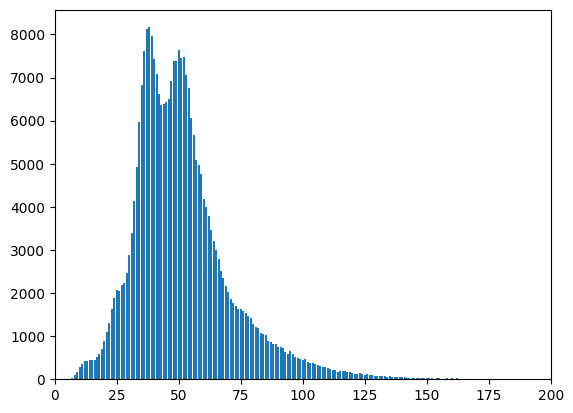

In [9]:
import matplotlib.pyplot as plt
import numpy as np

data = {}
for sen in dataset["train"]["highlights"]:
    l = len(sen.split())
    data[l] = data.get(l, 0) + 1

plt.xlim(0, 200)

plt.bar(data.keys(),data.values())
plt.show()

In [10]:
'''
    Try it out! 
    Once you’ve worked through this section, see how well mT5 compares to mBART by fine-tuning the latter with the same techniques. For bonus points, you can also try fine-tuning T5 on just the English reviews. Since T5 has a special prefix prompt, you’ll need to prepend summarize: to the input examples in the preprocessing steps below.

    I passed it!
'''
pass

### Preprocessing the data

In [3]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, legacy=False)

/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [6]:
inputs = tokenizer("I loved reading the Huger Games!")
inputs

{'input_ids': [336, 259, 28387, 11807, 287, 79622, 295, 12507, 309, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [7]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

['▁I', '▁', 'loved', '▁reading', '▁the', '▁Hug', 'er', '▁Games', '!', '</s>']

In [4]:
max_input_length = 512
max_target_length = 30

def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"], max_length=max_input_length, truncation=True,
    )
    labels = tokenizer(
        examples["highlights"], max_length=max_target_length, truncation=True,
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [5]:
tokenized_datasets = dataset.map(preprocess_function, batched=True, num_proc=8)

### Metrics for text summarization

In [76]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

In [ ]:
!pip install rouge_score

In [6]:
import evaluate

rouge_score = evaluate.load("rouge")

In [78]:
# There aren't details. you can find the reason why it only prints the f1 scores. (https://github.com/huggingface/evaluate/blob/main/metrics/rouge/rouge.py#L122)
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary],
)
scores

{'rouge1': 0.923076923076923,
 'rouge2': 0.7272727272727272,
 'rougeL': 0.923076923076923,
 'rougeLsum': 0.923076923076923}

In [79]:
# You can see more details like precision and recall .
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], use_stemmer=True)
rouge_scores = scorer.score(reference_summary,generated_summary)
rouge_scores

{'rouge1': Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923),
 'rouge2': Score(precision=0.6666666666666666, recall=0.8, fmeasure=0.7272727272727272),
 'rougeL': Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923),
 'rougeLsum': Score(precision=0.8571428571428571, recall=1.0, fmeasure=0.923076923076923)}

In [19]:
# scores["rouge1"].mid # There aren't low, mid, high values.

In [20]:
'''
    Try it out! 
    Create your own example of a generated and reference summary and see if the resulting ROUGE scores agree with a manual calculation based on the formulas for precision and recall. 
    For bonus points, split the text into bigrams and compare the precision and recall for the rouge2 metric.

    I passed it.
'''
pass

In [ ]:
!pip install nltk

In [7]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/fds/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
from nltk.tokenize import sent_tokenize

def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

print(three_sentence_summary(dataset["train"][1]["article"]))

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."


In [23]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["article"]]
    return metric.compute(predictions=summaries, references=dataset["highlights"])

In [24]:
import pandas as pd

score = evaluate_baseline(dataset["validation"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rough_dict = dict((rn, round(score[rn] * 100, 2)) for rn in rouge_names)
rough_dict

{'rouge1': 39.48, 'rouge2': 17.56, 'rougeL': 24.95, 'rougeLsum': 36.11}

### Fine-tuning mT5 with the Trainer API

In [12]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [14]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 8
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-cnn-dailymail-en_nlp-course-chapter7-section4",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
    report_to='none'
)

In [15]:
import numpy as np
from nltk.tokenize import sent_tokenize

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]

    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )

    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [11]:
from transformers import DataCollatorForSeq2Seq 

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [12]:
tokenized_datasets = tokenized_datasets.remove_columns(
    dataset["train"].column_names
)

In [13]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[ 24728, 177913,    261,  ...,   5176,    295,      1],
        [ 28544,    277,    263,  ...,    259,   6661,      1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'labels': tensor([[ 22930,  51258,   4527,   7330,   8120, 110375,    265,   1689,    263,
           5883,   1117,    511,    259, 124624,    527,    790,   8276,    263,
            812,  15914,    259,    260,  19267,  38519,    259,   6661,    790,
           1070,    375,      1],
        [ 82085,    484,    259,   8174,    281,  63038,    281,  29804,    418,
           6956,    285,    351,    287,    313,   1565,    318,  29280,  17070,
            311,  35831,   1017,  51257,    764,   1398,    823,    259,   6661,
           2250,    418,      1]]), 'decoder_input_ids': tensor([[     0,  22930,  51258,   4527,   7330,   8120, 110375,    265,   1689,
            263,   5883,   1117,    511,    259, 124624,    527,    790,   8276,
            263,   

In [19]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [20]:
trainer.train()

  0%|          | 0/287120 [00:00<?, ?it/s]

{'loss': 2.5643, 'learning_rate': 4.900019504040123e-05, 'epoch': 1.0}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1437 [00:00<?, ?it/s]

{'eval_loss': 1.8832327127456665, 'eval_rouge1': 32.0495, 'eval_rouge2': 16.2168, 'eval_rougeL': 28.2966, 'eval_rougeLsum': 30.0297, 'eval_runtime': 508.9854, 'eval_samples_per_second': 22.574, 'eval_steps_per_second': 2.823, 'epoch': 1.0}
{'loss': 2.2043, 'learning_rate': 4.2000390080802455e-05, 'epoch': 2.0}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1437 [00:00<?, ?it/s]

{'eval_loss': 1.7912617921829224, 'eval_rouge1': 32.3942, 'eval_rouge2': 16.6084, 'eval_rougeL': 28.6015, 'eval_rougeLsum': 30.3686, 'eval_runtime': 502.9752, 'eval_samples_per_second': 22.844, 'eval_steps_per_second': 2.857, 'epoch': 2.0}
{'loss': 2.1059, 'learning_rate': 3.500058512120368e-05, 'epoch': 3.0}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1437 [00:00<?, ?it/s]

{'eval_loss': 1.7544925212860107, 'eval_rouge1': 32.5226, 'eval_rouge2': 16.7984, 'eval_rougeL': 28.8285, 'eval_rougeLsum': 30.5446, 'eval_runtime': 495.8076, 'eval_samples_per_second': 23.174, 'eval_steps_per_second': 2.898, 'epoch': 3.0}
{'loss': 2.0453, 'learning_rate': 2.80007801616049e-05, 'epoch': 4.0}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1437 [00:00<?, ?it/s]

{'eval_loss': 1.7310693264007568, 'eval_rouge1': 32.4746, 'eval_rouge2': 16.7548, 'eval_rougeL': 28.7544, 'eval_rougeLsum': 30.4887, 'eval_runtime': 491.2737, 'eval_samples_per_second': 23.388, 'eval_steps_per_second': 2.925, 'epoch': 4.0}
{'loss': 2.0033, 'learning_rate': 2.100097520200613e-05, 'epoch': 5.0}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1437 [00:00<?, ?it/s]

{'eval_loss': 1.7098536491394043, 'eval_rouge1': 33.1011, 'eval_rouge2': 17.2836, 'eval_rougeL': 29.3355, 'eval_rougeLsum': 31.0773, 'eval_runtime': 490.5158, 'eval_samples_per_second': 23.424, 'eval_steps_per_second': 2.93, 'epoch': 5.0}
{'loss': 1.9721, 'learning_rate': 1.4001170242407355e-05, 'epoch': 6.0}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1437 [00:00<?, ?it/s]

{'eval_loss': 1.6970232725143433, 'eval_rouge1': 33.0955, 'eval_rouge2': 17.1866, 'eval_rougeL': 29.2639, 'eval_rougeLsum': 31.0288, 'eval_runtime': 484.0731, 'eval_samples_per_second': 23.736, 'eval_steps_per_second': 2.969, 'epoch': 6.0}
{'loss': 1.9501, 'learning_rate': 7.001365282808581e-06, 'epoch': 7.0}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1437 [00:00<?, ?it/s]

{'eval_loss': 1.6915135383605957, 'eval_rouge1': 33.2428, 'eval_rouge2': 17.3318, 'eval_rougeL': 29.4191, 'eval_rougeLsum': 31.1813, 'eval_runtime': 492.0728, 'eval_samples_per_second': 23.35, 'eval_steps_per_second': 2.92, 'epoch': 7.0}
{'loss': 1.9355, 'learning_rate': 1.5603232098077457e-09, 'epoch': 8.0}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1437 [00:00<?, ?it/s]

{'eval_loss': 1.685614824295044, 'eval_rouge1': 33.1062, 'eval_rouge2': 17.2193, 'eval_rougeL': 29.2904, 'eval_rougeLsum': 31.0641, 'eval_runtime': 497.0411, 'eval_samples_per_second': 23.117, 'eval_steps_per_second': 2.891, 'epoch': 8.0}
{'train_runtime': 119460.7094, 'train_samples_per_second': 19.227, 'train_steps_per_second': 2.403, 'train_loss': 2.097575862715257, 'epoch': 8.0}


TrainOutput(global_step=287120, training_loss=2.097575862715257, metrics={'train_runtime': 119460.7094, 'train_samples_per_second': 19.227, 'train_steps_per_second': 2.403, 'train_loss': 2.097575862715257, 'epoch': 8.0})

In [21]:
trainer.evaluate()

  0%|          | 0/1437 [00:00<?, ?it/s]

{'eval_loss': 1.685614824295044,
 'eval_rouge1': 33.1062,
 'eval_rouge2': 17.2193,
 'eval_rougeL': 29.2904,
 'eval_rougeLsum': 31.0641,
 'eval_runtime': 505.1971,
 'eval_samples_per_second': 22.744,
 'eval_steps_per_second': 2.844,
 'epoch': 8.0}

In [22]:
trainer.push_to_hub(commit_message="Training complete", tags="summarization")

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

'https://huggingface.co/BanUrsus/mt5-small-finetuned-cnn-dailymail-en_nlp-course-chapter7-section4/tree/main/'

###  Fine-tuning mT5 with 🤗 Accelerate

In [14]:
tokenized_datasets.set_format("torch")

In [9]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [15]:
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, collate_fn=data_collator,  batch_size=batch_size,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator,  batch_size=batch_size,
)

In [16]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [17]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [18]:
from transformers import get_scheduler

num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [19]:
import nltk

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [20]:
from huggingface_hub import get_full_repo_name

model_name = model_checkpoint.split("/")[-1]
model_name = f"{model_name}-finetuned-cnn-dailymail-en-accelerate_nlp-course-chapter7-section4"
repo_name = get_full_repo_name(model_name)
repo_name

'BanUrsus/mt5-small-finetuned-cnn-dailymail-en-accelerate_nlp-course-chapter7-section4'

In [23]:
from huggingface_hub import Repository

output_dir = model_name.split("_")[0]
repo = Repository(output_dir, clone_from=repo_name)

/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/BanUrsus/mt5-small-finetuned-cnn-dailymail-en-accelerate_nlp-course-chapter7-section4 into local empty directory.


In [24]:
from tqdm.auto import tqdm
import torch
import numpy as np

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
            )

            generated_tokens = accelerator.pad_across_processes(
                generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
            )
            labels = batch["labels"]

            labels = accelerator.pad_across_processes(
                batch["labels"], dim=1, pad_index=tokenizer.pad_token_id
            )

            generated_tokens = accelerator.gather(generated_tokens).cpu().numpy()
            labels = accelerator.gather(labels).cpu().numpy()
            
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            if isinstance(generated_tokens, tuple):
                generated_tokens = generated_tokens[0]
            decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

            rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)

    # Compute metrics
    result = rouge_score.compute()
    # Extract the ROUGE scores
    result = {key: value * 100 for key, value in result.items()}
    result = {k: round(v, 4) for k, v in result.items()}
    print(f"Epoch {epoch}:", result)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message="Training in progress epoch {epoch}", blocking=False
        )

  0%|          | 0/358900 [00:00<?, ?it/s]

/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 0: {'rouge1': 30.625, 'rouge2': 15.6404, 'rougeL': 27.2331, 'rougeLsum': 28.7911}


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.
/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 1: {'rouge1': 31.0346, 'rouge2': 15.9672, 'rougeL': 27.694, 'rougeLsum': 29.2624}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 2: {'rouge1': 31.0185, 'rouge2': 15.9997, 'rougeL': 27.6813, 'rougeLsum': 29.252}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 3: {'rouge1': 31.399, 'rouge2': 16.2569, 'rougeL': 27.993, 'rougeLsum': 29.5981}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 4: {'rouge1': 31.4946, 'rouge2': 16.3888, 'rougeL': 28.0833, 'rougeLsum': 29.71}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 5: {'rouge1': 31.6275, 'rouge2': 16.489, 'rougeL': 28.1862, 'rougeLsum': 29.8007}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 6: {'rouge1': 31.772, 'rouge2': 16.6124, 'rougeL': 28.3111, 'rougeLsum': 29.9253}


/home/fds/miniconda3/envs/py310_torch/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Epoch 7: {'rouge1': 31.8761, 'rouge2': 16.6604, 'rougeL': 28.392, 'rougeLsum': 30.0104}


In [ ]:
repo.push_to_hub(commit_message="Training complete", tags="summarization")

### Using your fine-tuned model

In [ ]:
from transformers import pipeline

hub_model_id = "BanUrsus/ ??"
summarizer = pipeline("summarization", model=hub_model_id)

In [ ]:
def print_summary(idx):
    article = dataset["test"][idx]["article"]
    highlights = dataset["test"][idx]["highlights"]
    summary = summarizer(article)[0]["summary_text"]
    print(f"'>>> Article: {article}'")
    print(f"\n'>>> Highlights: {highlights}'")
    print(f"\n'>>> Summary: {summary}'")

In [ ]:
print_summary(100)

In [ ]:
print_summary(0)

## Example

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset

spanish_dataset = load_dataset("amazon_reviews_multi", "es")
english_dataset = load_dataset("amazon_reviews_multi", "en")
english_dataset

In [ ]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Title: {example['review_title']}'")
        print(f"'>> Review: {example['review_body']}'")


show_samples(english_dataset)

In [ ]:
english_dataset.set_format("pandas")
english_df = english_dataset["train"][:]
# Show counts for top 20 products
english_df["product_category"].value_counts()[:20]

In [ ]:
def filter_books(example):
    return (
        example["product_category"] == "book"
        or example["product_category"] == "digital_ebook_purchase"
    )

In [ ]:
english_dataset.reset_format()

In [ ]:
spanish_books = spanish_dataset.filter(filter_books)
english_books = english_dataset.filter(filter_books)
show_samples(english_books)

In [ ]:
from datasets import concatenate_datasets, DatasetDict

books_dataset = DatasetDict()

for split in english_books.keys():
    books_dataset[split] = concatenate_datasets(
        [english_books[split], spanish_books[split]]
    )
    books_dataset[split] = books_dataset[split].shuffle(seed=42)

# Peek at a few examples
show_samples(books_dataset)

In [ ]:
books_dataset = books_dataset.filter(lambda x: len(x["review_title"].split()) > 2)

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
inputs = tokenizer("I loved reading the Hunger Games!")
inputs

In [ ]:
tokenizer.convert_ids_to_tokens(inputs.input_ids)

In [ ]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["review_body"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["review_title"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_datasets = books_dataset.map(preprocess_function, batched=True)

In [ ]:
generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"

In [ ]:
!pip install rouge_score

In [ ]:
import evaluate

rouge_score = evaluate.load("rouge")

In [ ]:
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

In [ ]:
scores["rouge1"].mid

In [ ]:
!pip install nltk

In [ ]:
import nltk

nltk.download("punkt")

In [ ]:
from nltk.tokenize import sent_tokenize


def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(books_dataset["train"][1]["review_body"]))

In [ ]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["review_body"]]
    return metric.compute(predictions=summaries, references=dataset["review_title"])

In [ ]:
import pandas as pd

score = evaluate_baseline(books_dataset["validation"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn].mid.fmeasure * 100, 2)) for rn in rouge_names)
rouge_dict

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-amazon-en-es",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(
    books_dataset["train"].column_names
)

In [ ]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
tokenized_datasets.set_format("torch")

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=batch_size
)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # ROUGE expects a newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "test-bert-finetuned-squad-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

In [ ]:
from huggingface_hub import Repository

output_dir = "results-mt5-finetuned-squad-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

In [ ]:
from tqdm.auto import tqdm
import torch
import numpy as np

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
            )

            generated_tokens = accelerator.pad_across_processes(
                generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
            )
            labels = batch["labels"]

            # If we did not pad to max length, we need to pad the labels too
            labels = accelerator.pad_across_processes(
                batch["labels"], dim=1, pad_index=tokenizer.pad_token_id
            )

            generated_tokens = accelerator.gather(generated_tokens).cpu().numpy()
            labels = accelerator.gather(labels).cpu().numpy()

            # Replace -100 in the labels as we can't decode them
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            if isinstance(generated_tokens, tuple):
                generated_tokens = generated_tokens[0]
            decoded_preds = tokenizer.batch_decode(
                generated_tokens, skip_special_tokens=True
            )
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            decoded_preds, decoded_labels = postprocess_text(
                decoded_preds, decoded_labels
            )

            rouge_score.add_batch(predictions=decoded_preds, references=decoded_labels)

    # Compute metrics
    result = rouge_score.compute()
    # Extract the median ROUGE scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    result = {k: round(v, 4) for k, v in result.items()}
    print(f"Epoch {epoch}:", result)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

In [ ]:
from transformers import pipeline

hub_model_id = "huggingface-course/mt5-small-finetuned-amazon-en-es"
summarizer = pipeline("summarization", model=hub_model_id)

In [ ]:
def print_summary(idx):
    review = books_dataset["test"][idx]["review_body"]
    title = books_dataset["test"][idx]["review_title"]
    summary = summarizer(books_dataset["test"][idx]["review_body"])[0]["summary_text"]
    print(f"'>>> Review: {review}'")
    print(f"\n'>>> Title: {title}'")
    print(f"\n'>>> Summary: {summary}'")

In [ ]:
print_summary(100)

In [ ]:
print_summary(0)

# Training a causal language model from scratch (Pytorch)

## Practice

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
!apt install git-lfs

In [ ]:
# !git config --global user.email "you@example.com"
# !git config --global user.name "Your Name"

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### Gathering the data

In [ ]:
def any_keyword_in_string(string, keywords):
    for keyword in keywords:
        if keyword in string:
            return True
    return False

In [ ]:
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]
example_1 = "import numpy as np"
example_2 = "import pandas as pd"

print(any_keyword_in_string(example_1, filters), any_keyword_in_string(example_2, filters))

In [ ]:
from collections import defaultdict
from tqdm import tqdm
from datasets import Dataset

def filter_streaming_dataset(dataset, filters):
    filtered_dict = defaultdict(list)
    total = 0
    for sample in tqdm(iter(dataset)):
        total += 1
        if any_keyword_in_string(sample["content"], filters):
            for k, v in sample.items():
                filtered_dict[k].append(v)
    print(f"{len(filtered_dict["content"]) / total:.2%} of data after filtering.")
    return Dataset.from_dict(filtered_dict)

In [ ]:
# This cell will take a very long time to execute, so you should skip it and go to the next one!
from datasets import load_dataset

split = "train" # "valid"
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]

data = load_dataset(f"transformersbook/codeparrot-{split}", split=split, streaming=True)
filtered_data = filter_streaming_dataset(data, filters)

In [ ]:
from datasets import load_dataset, DatasetDict

ds_train = load_dataset("huggingface-course/codeparrot-ds-train", split="train")
ds_valid = load_dataset("huggingface-course/codeparrot-ds-valid", split="validation")

raw_datasets = DatasetDict(
    {
        "train": ds_train,
        "valid": ds_valid,
    }
)

raw_datasets

In [ ]:
for key in raw_datasets["train"][0]:
    print(f"{key.upper()}: {raw_datasets["train"][0][key][:200]}")

### Preparing the dataset

In [ ]:
from transformers import AutoTokenizer

context_length = 128
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

outputs = tokenizer(
    raw_datasets["train"][:2]["content"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length: {len(outputs["input_ids"])}")
print(f"Input chunk lengths: {(outputs["length"])}")
print(f"Chunk mapping: {outputs["overflow_to_sample_mapping"]}")

In [ ]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

In [ ]:
'''
    Try it out!
'''

### Initializing a new model (with Trainer)

In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

In [ ]:
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

In [ ]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [ ]:
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments 

batch_size = 32

args = TrainingArguments(
    output_dir="",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=True,
    push_to_hub=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
)

In [ ]:
trainer.train()

In [ ]:
trainer.push_to_hub(commit_message="Training complete", tags="text-generation")

In [ ]:
'''
    Try it out!
'''

### Code generation with a pipeline

In [ ]:
import torch
from transformers import pipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pipe = pipeline("text-generation", model="BanU", device=device)

In [ ]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

In [ ]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

In [ ]:
txt = """\
# dataframe with profession, income and name
df = pd.DataFrame({'profession': x, 'income':y, 'name': z})

# calculate the mean income per profession
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

In [ ]:
txt = """
# import random forest regressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor

# fit random forest model with 300 estimators on X, y:
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

### Training with 🤗 Accelerate

In [ ]:
keytoken_ids = []
for keyword in [
    "plt",
    "pd",
    "sk",
    "fit",
    "predict",
    " plt",
    " pd",
    " sk",
    " fit",
    " predict",
    "testtest",
]:
    ids = tokenize([keyword]).input_ids[0]
    if len(ids) == 1:
        keytoken_ids.append(ids[0])
    else:
        print(f"Keyword has not single token: {keyword}")

In [ ]:
from torch.nn import CrossEntropyLoss
import torch

def keytoken_weighted_loss(inputs, logits, keytoken_ids, alpha=1.0):
    shift_labels = inputs[..., 1:].contiguous()
    shift_logits = logits[..., :-1, :].contiguous()

    loss_fct = CrossEntropyLoss(reduce=False)
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.size(-1))

    loss_per_sample = loss.view(shift_logits.size(0), shift_logits.size(1)).mean(axis=1)

    weights = torch.stack([(inputs == kt).float() for kt in keytoken_ids]).sum(axis=[0, 2])
    weights = alpha * (1.0 + weights)
    
    weighted_loss = (loss_per_sample * weights).mean()
    return weighted_loss

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32

tokenized_dataset.set_format("torch")
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(tokenized_dataset["valid"], batch_size=batch_size)

In [ ]:
weights_decay = 0.1

def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"]):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [
        {"params": params_with_wd, "weight_decay": weights_decay},
        {"params": params_without_wd, "weight_decay": 0.0},
    ]

In [ ]:
def evaluate():
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])

        losses.append(accelerator.gather(outputs.loss))
    loss = torch.mean(torch.cat(losses))
    try:
        perplexity = torch.exp(loss)
    except OverflowError:
        perplexity = float("inf")
    return loss.item(), perplexity.item()

In [ ]:
model  = GPT2LMHeadModel(config)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(get_grouped_params(model), lr=5e-4)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader, 
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 1
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=1_000,
    num_training_steps=num_training_steps,
)

In [ ]:
from huggingface_hub import Repository, get_full_repo_name

model_name = ""
repo_name = get_full_repo_name(model_name)
repo_name

In [ ]:
output_dir = ""
repo = Repository(output_dir, clone_from=repo_name)

In [ ]:
evaluate()

In [ ]:
from tqdm.notebook import tqdm

gradient_accumulation_steps = 8
eval_steps = 5_000

model.train()
completed_steps = 0
for epoch in range(num_train_epochs):
    for step, batch in tqdm(enumerate(train_dataloader, start=1), total=num_training_steps):
        logits = model(batch["input_ids"]).logits
        loss = keytoken_weighted_loss(batch["input_ids"], logits, keytoken_ids)
        if step % 100 == 0:
            accelerator.print(
                {
                    "lr": get_lr(),
                    "samples": step * samples_per_step,
                    "steps": completed_steps,
                    "loss/train": loss.items() * gradient_accumulation_steps,
                }
            )
        loss = loss / gradient_accumulation_steps
        accelerator.backward(loss)
        if step % gradient_accumulation_steps == 0:
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            completed_steps += 1
        if (step % (eval_steps * gradient_accumulation_steps)) == 0:
            eval_loss, perplexity = evaluate()
            accelerator.print({"loss/eval": eval_loss, "preplexity": perplexity})
            model.train()
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
            if accelerator.is_main_process:
                tokenizer.save_pretrained(output_dir)
                repo.push_to_hub(commit_message=f"Training in progress step {step}", blocking=False)

In [ ]:
'''
    Try it out!
'''

In [ ]:
'''
    Try it out!
'''

## Example

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
def any_keyword_in_string(string, keywords):
    for keyword in keywords:
        if keyword in string:
            return True
    return False

In [ ]:
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]
example_1 = "import numpy as np"
example_2 = "import pandas as pd"

print(
    any_keyword_in_string(example_1, filters), any_keyword_in_string(example_2, filters)
)

In [ ]:
from collections import defaultdict
from tqdm import tqdm
from datasets import Dataset


def filter_streaming_dataset(dataset, filters):
    filtered_dict = defaultdict(list)
    total = 0
    for sample in tqdm(iter(dataset)):
        total += 1
        if any_keyword_in_string(sample["content"], filters):
            for k, v in sample.items():
                filtered_dict[k].append(v)
    print(f"{len(filtered_dict['content'])/total:.2%} of data after filtering.")
    return Dataset.from_dict(filtered_dict)

In [ ]:
# This cell will take a very long time to execute, so you should skip it and go to
# the next one!
from datasets import load_dataset

split = "train"  # "valid"
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]

data = load_dataset(f"transformersbook/codeparrot-{split}", split=split, streaming=True)
filtered_data = filter_streaming_dataset(data, filters)

In [ ]:
from datasets import load_dataset, DatasetDict

ds_train = load_dataset("huggingface-course/codeparrot-ds-train", split="train")
ds_valid = load_dataset("huggingface-course/codeparrot-ds-valid", split="validation")

raw_datasets = DatasetDict(
    {
        "train": ds_train,  # .shuffle().select(range(50000)),
        "valid": ds_valid,  # .shuffle().select(range(500))
    }
)

raw_datasets

In [ ]:
for key in raw_datasets["train"][0]:
    print(f"{key.upper()}: {raw_datasets['train'][0][key][:200]}")

In [ ]:
from transformers import AutoTokenizer

context_length = 128
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

outputs = tokenizer(
    raw_datasets["train"][:2]["content"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

In [ ]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}


tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

In [ ]:
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

In [ ]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [ ]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="codeparrot-ds",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
)

In [ ]:
trainer.train()

In [ ]:
trainer.push_to_hub()

In [ ]:
import torch
from transformers import pipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pipe = pipeline(
    "text-generation", model="huggingface-course/codeparrot-ds", device=device
)

In [ ]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

In [ ]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

In [ ]:
txt = """\
# dataframe with profession, income and name
df = pd.DataFrame({'profession': x, 'income':y, 'name': z})

# calculate the mean income per profession
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

In [ ]:
txt = """
# import random forest regressor from scikit-learn
from sklearn.ensemble import RandomForestRegressor

# fit random forest model with 300 estimators on X, y:
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

In [ ]:
keytoken_ids = []
for keyword in [
    "plt",
    "pd",
    "sk",
    "fit",
    "predict",
    " plt",
    " pd",
    " sk",
    " fit",
    " predict",
    "testtest",
]:
    ids = tokenizer([keyword]).input_ids[0]
    if len(ids) == 1:
        keytoken_ids.append(ids[0])
    else:
        print(f"Keyword has not single token: {keyword}")

In [ ]:
from torch.nn import CrossEntropyLoss
import torch


def keytoken_weighted_loss(inputs, logits, keytoken_ids, alpha=1.0):
    # Shift so that tokens < n predict n
    shift_labels = inputs[..., 1:].contiguous()
    shift_logits = logits[..., :-1, :].contiguous()
    # Calculate per-token loss
    loss_fct = CrossEntropyLoss(reduce=False)
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    # Resize and average loss per sample
    loss_per_sample = loss.view(shift_logits.size(0), shift_logits.size(1)).mean(axis=1)
    # Calculate and scale weighting
    weights = torch.stack([(inputs == kt).float() for kt in keytoken_ids]).sum(
        axis=[0, 2]
    )
    weights = alpha * (1.0 + weights)
    # Calculate weighted average
    weighted_loss = (loss_per_sample * weights).mean()
    return weighted_loss

In [ ]:
from torch.utils.data.dataloader import DataLoader

tokenized_dataset.set_format("torch")
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=32, shuffle=True)
eval_dataloader = DataLoader(tokenized_dataset["valid"], batch_size=32)

In [ ]:
weight_decay = 0.1


def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"]):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [
        {"params": params_with_wd, "weight_decay": weight_decay},
        {"params": params_without_wd, "weight_decay": 0.0},
    ]

In [ ]:
def evaluate():
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])

        losses.append(accelerator.gather(outputs.loss))
    loss = torch.mean(torch.cat(losses))
    try:
        perplexity = torch.exp(loss)
    except OverflowError:
        perplexity = float("inf")
    return loss.item(), perplexity.item()

In [ ]:
model = GPT2LMHeadModel(config)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(get_grouped_params(model), lr=5e-4)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator(fp16=True)

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 1
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=1_000,
    num_training_steps=num_training_steps,
)

In [ ]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "codeparrot-ds-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

In [ ]:
output_dir = "codeparrot-ds-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

In [ ]:
evaluate()

In [ ]:
from tqdm.notebook import tqdm

gradient_accumulation_steps = 8
eval_steps = 5_000

model.train()
completed_steps = 0
for epoch in range(num_train_epochs):
    for step, batch in tqdm(
        enumerate(train_dataloader, start=1), total=num_training_steps
    ):
        logits = model(batch["input_ids"]).logits
        loss = keytoken_weighted_loss(batch["input_ids"], logits, keytoken_ids)
        if step % 100 == 0:
            accelerator.print(
                {
                    "lr": get_lr(),
                    "samples": step * samples_per_step,
                    "steps": completed_steps,
                    "loss/train": loss.item() * gradient_accumulation_steps,
                }
            )
        loss = loss / gradient_accumulation_steps
        accelerator.backward(loss)
        if step % gradient_accumulation_steps == 0:
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            completed_steps += 1
        if (step % (eval_steps * gradient_accumulation_steps)) == 0:
            eval_loss, perplexity = evaluate()
            accelerator.print({"loss/eval": eval_loss, "perplexity": perplexity})
            model.train()
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
            if accelerator.is_main_process:
                tokenizer.save_pretrained(output_dir)
                repo.push_to_hub(
                    commit_message=f"Training in progress step {step}", blocking=False
                )

# Question answering (PyTorch)

## Practice

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
!apt install git-lfs

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### Preparing the data

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("squad")

In [ ]:
raw_datasets

In [ ]:
print("Context: ", raw_datasets["train"][0]["context"])
print("Question: ", raw_datasets["train"][0]["question"])
print("Answer: ", raw_datasets["train"][0]["answers"])

In [ ]:
raw_datasets["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

In [ ]:
print(raw_datasets["validation"][0]["answers"])
print(raw_datasets["validation"][2]["answers"])

In [ ]:
print(raw_datasets["validation"][2]["context"])
print(raw_datasets["validation"][2]["question"])

### Fine-tuning the model with the Trainer API

### A custom training loop

### Using the fine-tuned model

## Example

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("squad")

In [ ]:
raw_datasets

In [ ]:
print("Context: ", raw_datasets["train"][0]["context"])
print("Question: ", raw_datasets["train"][0]["question"])
print("Answer: ", raw_datasets["train"][0]["answers"])

In [ ]:
raw_datasets["train"].filter(lambda x: len(x["answers"]["text"]) != 1)

In [ ]:
print(raw_datasets["validation"][0]["answers"])
print(raw_datasets["validation"][2]["answers"])

In [ ]:
print(raw_datasets["validation"][2]["context"])
print(raw_datasets["validation"][2]["question"])

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
tokenizer.is_fast

In [ ]:
context = raw_datasets["train"][0]["context"]
question = raw_datasets["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

In [ ]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids))

In [ ]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)
inputs.keys()

In [ ]:
inputs["overflow_to_sample_mapping"]

In [ ]:
inputs = tokenizer(
    raw_datasets["train"][2:6]["question"],
    raw_datasets["train"][2:6]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

In [ ]:
answers = raw_datasets["train"][2:6]["answers"]
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

start_positions, end_positions

In [ ]:
idx = 0
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Theoretical answer: {answer}, labels give: {labeled_answer}")

In [ ]:
idx = 4
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

decoded_example = tokenizer.decode(inputs["input_ids"][idx])
print(f"Theoretical answer: {answer}, decoded example: {decoded_example}")

In [ ]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset)

In [ ]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

In [ ]:
small_eval_set = raw_datasets["validation"].select(range(100))
trained_checkpoint = "distilbert-base-cased-distilled-squad"

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch)

In [ ]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy()

In [ ]:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

In [ ]:
import numpy as np

n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example["id"]
    context = example["context"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip answers with a length that is either < 0 or > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

In [ ]:
import evaluate

metric = evaluate.load("squad")

In [ ]:
theoretical_answers = [
    {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set
]

In [ ]:
print(predicted_answers[0])
print(theoretical_answers[0])

In [ ]:
metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
compute_metrics(start_logits, end_logits, eval_set, small_eval_set)

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-squad",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    fp16=True,
    push_to_hub=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)
trainer.train()

In [ ]:
predictions, _, _ = trainer.predict(validation_dataset)
start_logits, end_logits = predictions
compute_metrics(start_logits, end_logits, validation_dataset, raw_datasets["validation"])

In [ ]:
trainer.push_to_hub(commit_message="Training complete")

In [ ]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

train_dataset.set_format("torch")
validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=default_data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8
)

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator(fp16=True)
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "bert-finetuned-squad-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

In [ ]:
output_dir = "bert-finetuned-squad-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

In [ ]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    start_logits = []
    end_logits = []
    accelerator.print("Evaluation!")
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
        end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

    start_logits = np.concatenate(start_logits)
    end_logits = np.concatenate(end_logits)
    start_logits = start_logits[: len(validation_dataset)]
    end_logits = end_logits[: len(validation_dataset)]

    metrics = compute_metrics(
        start_logits, end_logits, validation_dataset, raw_datasets["validation"]
    )
    print(f"epoch {epoch}:", metrics)

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

In [ ]:
accelerator.wait_for_everyone()
unwrapped_model = accelerator.unwrap_model(model)
unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "huggingface-course/bert-finetuned-squad"
question_answerer = pipeline("question-answering", model=model_checkpoint)

context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)